## Checkpoint Inspector

Loads folders of `json` checkpoints dumped by `train.lua` and visualizes training statistics.

In [1]:
import json

from scipy.misc import imread, imresize
import os

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# utility functions

def smooth(ys, alpha=0.9):
    """ take a list of numbers (ys) and do exponential smoothing """
    y2 = []
    acc = None
    for y in ys:
        if acc is None:
            acc = y
        else:
            acc = alpha * acc + (1-alpha) * y
        y2.append(acc)
    return y2

number of jsons:  5
loaded  5


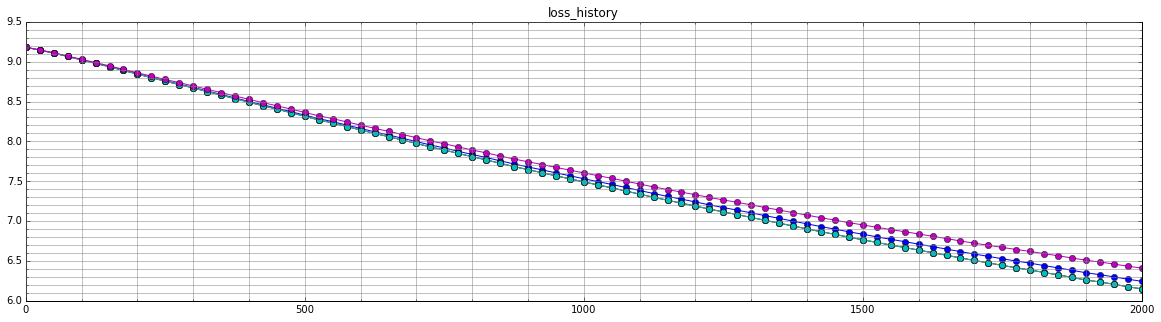

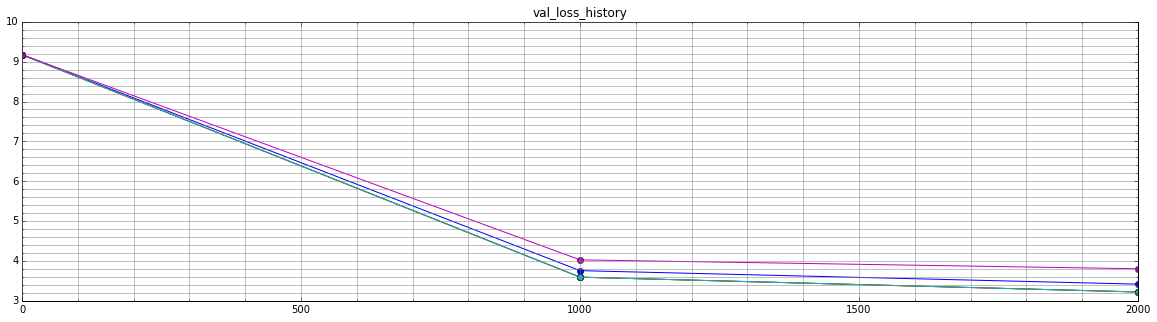

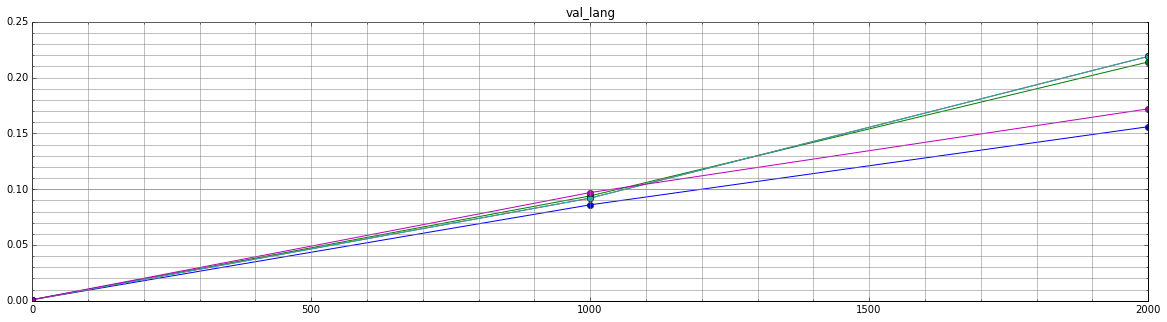

In [25]:
root = 'checkpoints'
files = os.listdir(root)
jsons = [x for x in files if x[-4:] == 'json']
print 'number of jsons: ', len(jsons)

blobs = [json.load(open(os.path.join(root,jp))) for jp in jsons]
print 'loaded ', len(blobs)

for b in blobs:
    if 'val_lang_stats_history' in b:
        b['val_lang'] = {k:v['CIDEr'] for k,v in b['val_lang_stats_history'].iteritems()}

optim_to_color = {'sgd':'r', 'rmsprop':'b', 'adam':'g'}
for key in ['loss_history', 'val_loss_history', 'val_lang']:
    # draw the training loss functions
    plt.figure(figsize=(20,5))
    maxx = 0
    for b in blobs:
        xs = sorted([int(x) for x in b[key].keys()])
        ys = [b[key][str(x)] for x in xs]
        ys = smooth(ys,{'loss_history':0.99, 'val_loss_history':0, 'val_lang':0}[key])
        c = optim_to_color[b['opt']['optim']]
        plt.plot(xs,ys,'-o')
        maxx = max(maxx, max(xs))
    plt.title(key)
#    if 'loss' in key:
#        plt.axis([0, maxx, 2.3, 2.4])
#    if 'lang' in key:
#        plt.axis([0, maxx, 0.8, 0.9])
    
    plt.minorticks_on()
    plt.grid(b=True, which='both', color='gray', linestyle='-')
    

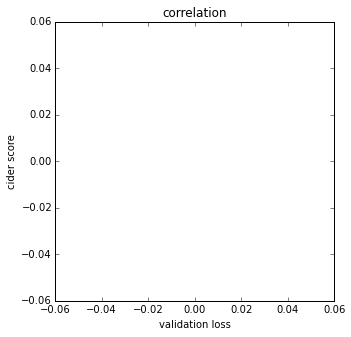

In [26]:
# lets look at the correlation between val loss and cider score
xs,ys = [],[]
for b in blobs:
    for i in b['val_loss_history'].keys():
        x = b['val_loss_history'][i]
        y = b['val_lang'][i]
        if x > 2.8: continue # skip
        xs.append(x)
        ys.append(y)
    
plt.figure(figsize=(5,5))
plt.scatter(xs,ys)
plt.xlabel('validation loss')
plt.ylabel('cider score')
plt.title('correlation')

In [27]:
# find the best performance for each blob
for b in blobs:
    xs = sorted([int(x) for x in b['val_lang'].keys()])
    ys = [b['val_lang'][str(x)] for x in xs]
    b['best_val'] = max(ys)

In [28]:
# find all the keys that were being cross-validated
ban = ['gpuid', 'seed', 'id', 'start_from']
keys = list(set(k for k in b['opt'] for b in blobs))
cvd = []
for k in keys:
    if k in ban: continue
    vals = list(set(b['opt'][k] for b in blobs if k in b['opt']))
    if len(vals) > 1: cvd.append(k)
print 'cross-validated: '
print cvd

cross-validated: 
[u'grad_clip']


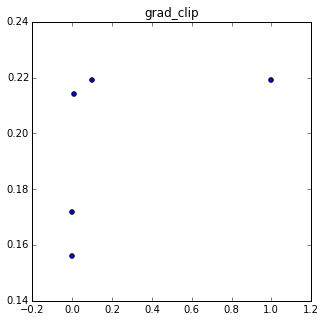

In [29]:
import math
plot_ban = ['optim']
plot_style = {'cnn_learning_rate':'log', 'learning_rate':'log', 'optim_alpha':'flat', 'optim_beta':'flat'}
optim_filter = 'adam'
for k in cvd:
    if k in plot_ban: continue
        
    xy = [(b['opt'][k], b['best_val']) for b in blobs if b['opt']['optim'] == optim_filter]
    xs,ys = zip(*xy)
    
    p = plot_style.get(k, 'flat')
    if p == 'log':
        xs = [math.log10(x) if x != 0 else 0 for x in xs]
    
    plt.figure(figsize=(5,5))
    plt.scatter(xs, ys)
    plt.title(k)

In [30]:
# print the best blobs in order
bs = [(b['best_val'], b['opt']) for b in blobs]
bs.sort()
print_keys = cvd + ['cnn_optim', 'id']
for vb in bs[:50]:
    s = ', '.join( '(%s: %s)' % (k, vb[1].get(k, '')) for k in print_keys)
    print '%f: %s' % (vb[0], s)
    print '----------------------------------------------------------'

0.156000: (grad_clip: 0.001), (cnn_optim: adam), (id: 1-82-1447996828)
----------------------------------------------------------
0.172000: (grad_clip: 0.0001), (cnn_optim: adam), (id: 0-310-1447996826)
----------------------------------------------------------
0.214000: (grad_clip: 0.01), (cnn_optim: adam), (id: 2-704-1447996830)
----------------------------------------------------------
0.219000: (grad_clip: 0.1), (cnn_optim: adam), (id: 3-636-1447996832)
----------------------------------------------------------
0.219000: (grad_clip: 1), (cnn_optim: adam), (id: 4-791-1447996834)
----------------------------------------------------------
